# Dota 2 - Regression Analysis

* Trying to predict the total score of two teams based full match data

# RUN THIS BLOCK ONCE

In [1]:
%%capture
!conda update --all -y
!pip install --upgrade setuptools
!pip install xgboost
!pip install keras
!pip install tensorflow

In [2]:
# API IMPORTS
from __future__ import print_function
import time
from pprint import pprint
import json
import ast
from sklearn.exceptions import DataConversionWarning


# BASIC IMPORTS
import warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
from scipy.stats import iqr

#SKLEARN IMPORTS
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import  MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# KERAS/TENSORFLOW IMPORTS
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


# XGBOOST IMPORTS
from xgboost import XGBClassifier

Using TensorFlow backend.


# Basic Stats

In [3]:
def simple_stats(df):
    sorted(df['total_score'])
    q1, q3= np.percentile(df['total_score'],[25,75])
    inter_range = iqr(df['total_score'])
    lower_bound = q1 -(1.5 * inter_range) 
    upper_bound = q3 +(1.5 * inter_range) 
    print("IQR: ", inter_range)
    print("LOW: ", lower_bound)
    print("HIGH: ", upper_bound)
    print("Q1: ", q1)
    print("Q3: ", q3)
    
    
    plt.violinplot(df['total_score'], showmedians=True)
    plt.ylabel("Total Score")
    plt.xticks([])
    plt.show()

## Compute Accuracy with Range

In [4]:
def accuracy_calc(yTest, predictions, spread):
    num_tests = yTest.size
    correct = 0
    
    for l1,l2 in zip(yTest, predictions):
        if abs(l1 - l2) < spread:
            correct = correct + 1
            
    return correct/num_tests

# Linear Regression

In [5]:
def lin_reg(df):
    x = df.drop(['total_score'], axis=1)
    y = df['total_score']

    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)
    linearRegressor = LinearRegression()
    linearRegressor.fit(xTrain, yTrain)
    yPrediction = linearRegressor.predict(xTest)

    predictions = [round(value) for value in yPrediction]

    accuracy = accuracy_score(yTest, predictions)
    print("LINEAR REGRESSION")
    print("---------------------------------")
    print("Exact Answer Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Accuracy with +/- 5 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 5) * 100.0))
    print("Accuracy with +/- 10 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 10) * 100.0))
    print("Accuracy with +/- 15 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 15) * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, predictions)))
    print()
    print()

# Random Forest Regression

In [6]:
def rand_for(df):
    x = df.drop(['total_score'], axis=1)
    y = df['total_score']

    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)
    forestRegressor = RandomForestRegressor(n_estimators=2000, max_depth=10)
    forestRegressor.fit(xTrain, yTrain)
    yPrediction = forestRegressor.predict(xTest)

    predictions = [round(value) for value in yPrediction]

    accuracy = accuracy_score(yTest, predictions)
    print("RANDOM FOREST REGRESSION")
    print("---------------------------------")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Accuracy with +/- 5 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 5) * 100.0))
    print("Accuracy with +/- 10 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 10) * 100.0))
    print("Accuracy with +/- 15 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 15) * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, predictions)))
    print()
    print()

# XGBoost

In [7]:
def xg_reg(df):
    x = df.drop(['total_score'], axis=1)
    y = df['total_score']

    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)

    # fit model no training data
    model = XGBClassifier(scale_pos_weight=1,
                          learning_rate=0.01,  
                          subsample = 0.8,
                          objective='reg:squarederror', 
                          n_estimators=2000, 
                          reg_alpha = 0.3,
                          max_depth=40, 
                          gamma=10)

    model.fit(xTrain, yTrain)

    # make predictions for test data
    yPrediction = model.predict(xTest)
    predictions = [round(value) for value in yPrediction]

    # evaluate predictions
    accuracy = accuracy_score(yTest, predictions)
    print("XGBOOST REGRESSION")
    print("---------------------------------")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Accuracy with +/- 5 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 5) * 100.0))
    print("Accuracy with +/- 10 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 10) * 100.0))
    print("Accuracy with +/- 15 Spread: %.2f%%" % (accuracy_calc(yTest, yPrediction, 15) * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, predictions)))
    print()
    print()

# Neural Network
* Inspiration from: https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [8]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [9]:
def model_2():
    # create model
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(75, kernel_initializer='normal', activation='relu'))
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [10]:
def nn_reg(df):
    x = df.drop(['patch','total_score'], axis=1)
    y = df['total_score'].values
    
    sc= MinMaxScaler()
    x= sc.fit_transform(x.astype(np.float))
    y= y.reshape(-1,1)
    y=sc.fit_transform(y.astype(np.float))
    
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

    
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)

    
    model = KerasRegressor(build_fn=larger_model, batch_size=5,epochs=5000, verbose=0, callbacks=[es])
    
    model.fit(xTrain,yTrain)

    # make predictions for test data
    yPrediction = model.predict(xTest)

    # evaluate predictions
    #accuracy = accuracy_score(yTest, yPrediction)
    print("NEURAL NETWORK REGRESSION")
    print("---------------------------------")
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, yPrediction)))
    print()
    print()

In [11]:
def nn_reg_model2(df):
    x = df.drop(['patch','total_score'], axis=1)
    y = df['total_score'].values
    
    sc= MinMaxScaler()
    x= sc.fit_transform(x.astype(np.float))
    y= y.reshape(-1,1)
    y=sc.fit_transform(y.astype(np.float))
    
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

    
    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5)

    
    model = KerasRegressor(build_fn=model_2, batch_size=5,epochs=5000, verbose=0, callbacks=[es])
    
    model.fit(xTrain,yTrain)

    # make predictions for test data
    yPrediction = model.predict(xTest)

    # evaluate predictions
    #accuracy = accuracy_score(yTest, yPrediction)
    print("NEURAL NETWORK REGRESSION - Model 2")
    print("---------------------------------")
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Root Mean Squared Error: %.2f" % sqrt(mean_squared_error(yTest, yPrediction)))
    print()
    print()

# Automate All Tests

In [12]:
def run_all(df):
    simple_stats(df)
    lin_reg(df)
    rand_for(df)
    xg_reg(df)
    nn_reg(df)
    nn_reg_model2(df)

### Data Dropping and Cleaning

* Removing all columns except for team scores and draft information

In [13]:
def drop_bulk(df):
    df = df.drop(axis=1, columns=['Unnamed: 0','Unnamed: 0.1', 'barracks_status_dire', 'barracks_status_radiant',
                                         'cluster', 'cosmetics', 'duration', 'radiant_xp_adv', 'region', 'series_id',
                                         'series_type', 'skill', 'start_time', 'throw', 'tower_status_dire', 
                                         'tower_status_radiant', 'version', 'engine', 'first_blood_time', 'game_mode',
                                         'league', 'leagueid', 'lobby_type', 'loss', 'match_id', 'match_seq_num', 
                                         'objectives', 'draft_timings', 'dire_team', 'radiant_gold_adv',
                                         'radiant_team', 'radiant_win'])
    df = df.dropna(axis=0)
    return df

In [14]:
def create_total(df):
    df["total_score"] = df["dire_score"] + df["radiant_score"]
    return df

In [15]:
def drop_bots(df):
    # Dropping rows that have a total score of 0 (extremely unlikely scenario, arguably impossible)
    # Dropping rows that do not have 10 human players participating 
    #    (means bots are playing and we do not want these included)

    df = df[df.total_score != 0]
    df = df[df.human_players == 10]
    return df

In [16]:
def collect_picks(row):
    picks = []
    json_string = row["picks_bans"]
    json_string = ast.literal_eval(json_string.replace("'",'"'))
    data = json.loads(json.dumps(json_string))
    picks = [data[v]['hero_id'] for v in range(len(data)) if data[v]['is_pick'] == True]
    return picks

In [17]:
def picks_wrapper(df):

    heroes_lists = []

    for index,row in df.iterrows():
        row = row.copy()
        picks = collect_picks(row)
        heroes_lists.append(picks)
        
        
    df['heroes'] = heroes_lists
    df = df.drop(axis=1, columns=['picks_bans'])
    
    return df

In [18]:
def columnize_heroes(df):
    df = df.drop(axis=1, columns=['dire_score', 'human_players', 'radiant_score'])
    df[['h1','h2','h3','h4','h5','h6','h7','h8','h9','h10']] = pd.DataFrame(df.heroes.values.tolist(), 
                                                                                index= df.index)
    df = df.drop(axis=1, columns=['heroes'])

    return df

In [19]:
def clean(df):
    print(df.shape)
    # Call other functions
    df = drop_bulk(df)
    df = create_total(df)
    df = drop_bots(df)
    df = picks_wrapper(df)
    df = columnize_heroes(df)
    print(df.shape)
    return df

## Read CSVs

In [20]:
df_prof = pd.read_csv("https://dota-match-ids.s3.amazonaws.com/raw_match_csvs/professional_raw_match_full.csv")
df_prof = clean(df_prof)
df_prof = df_prof.drop(['Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1'], axis=1)
df_prof.head()

(74339, 40)
(39606, 15)


,patch,total_score,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10
0,41.0,95.0,66,16,121,72,86,52,95,19,76,34
1,41.0,102.0,25,86,16,50,103,102,23,8,53,70
2,41.0,73.0,9,58,102,7,49,30,8,10,46,26
3,41.0,83.0,25,19,64,60,81,111,86,12,43,39
4,41.0,57.0,23,96,86,90,64,8,63,32,21,99


### See which patch versions we have

In [21]:
print(df_prof['patch'].unique())

[41. 40. 39. 38. 37. 36. 35. 34. 33. 31. 30. 29. 28. 27. 26. 25. 24. 23.
 22. 21. 20. 19. 18. 17. 16.]


### Get an idea for the amount of matches we have for each patch version

In [22]:
for i in range(min(df_prof['patch'].astype('int64')), max(df_prof['patch'].astype('int64')) + 1):
    print(df_prof.loc[df_prof['patch'] == i].shape)
    
#run_all(df_prof)

(905, 12)
(1573, 12)
(5717, 12)
(278, 12)
(1142, 12)
(932, 12)
(318, 12)
(499, 12)
(1417, 12)
(4109, 12)
(2500, 12)
(447, 12)
(234, 12)
(181, 12)
(504, 12)
(242, 12)
(0, 12)
(145, 12)
(328, 12)
(339, 12)
(226, 12)
(399, 12)
(2746, 12)
(2467, 12)
(4952, 12)
(7006, 12)


### Let's run our tests on patch versions where we have more than 2000 data points

PATCH VERSION:  18
Dataset shape for patch version:  (5717, 12)
---------------------------------------------
IQR:  23.0
LOW:  0.5
HIGH:  92.5
Q1:  35.0
Q3:  58.0


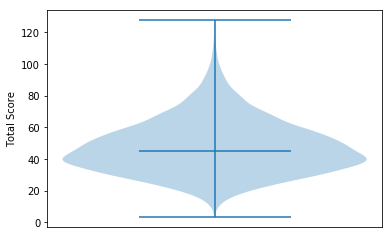

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 1.84%
Accuracy with +/- 5 Spread: 22.21%
Accuracy with +/- 10 Spread: 43.24%
Accuracy with +/- 15 Spread: 62.00%
Root Mean Squared Error: 17.43


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 2.45%
Accuracy with +/- 5 Spread: 22.61%
Accuracy with +/- 10 Spread: 44.86%
Accuracy with +/- 15 Spread: 62.88%
Root Mean Squared Error: 17.23


XGBOOST REGRESSION
---------------------------------
Accuracy: 2.75%
Accuracy with +/- 5 Spread: 22.39%
Accuracy with +/- 10 Spread: 44.08%
Accuracy with +/- 15 Spread: 60.87%
Root Mean Squared Error: 18.63


Epoch 00175: early stopping
NEURAL NETWORK REGRESSION
---------------------------------
Root Mean Squared Error: 0.14


Epoch 00231: early stopping
NEURAL NETWORK REGRESSION - Model 2
---------------------------------
Root Mean Squared Error: 0.14


PATCH VERSION:  25
Dataset shape for patch version:  (4109, 12)
-----------------------------------------

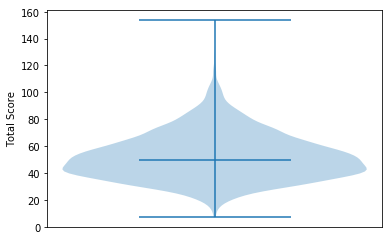

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 2.07%
Accuracy with +/- 5 Spread: 22.20%
Accuracy with +/- 10 Spread: 42.88%
Accuracy with +/- 15 Spread: 61.37%
Root Mean Squared Error: 17.28


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 2.25%
Accuracy with +/- 5 Spread: 22.38%
Accuracy with +/- 10 Spread: 43.19%
Accuracy with +/- 15 Spread: 62.10%
Root Mean Squared Error: 17.14


XGBOOST REGRESSION
---------------------------------
Accuracy: 2.62%
Accuracy with +/- 5 Spread: 20.01%
Accuracy with +/- 10 Spread: 39.60%
Accuracy with +/- 15 Spread: 59.18%
Root Mean Squared Error: 20.11


Epoch 00230: early stopping
NEURAL NETWORK REGRESSION
---------------------------------
Root Mean Squared Error: 0.12


Epoch 00258: early stopping
NEURAL NETWORK REGRESSION - Model 2
---------------------------------
Root Mean Squared Error: 0.13


PATCH VERSION:  26
Dataset shape for patch version:  (2500, 12)
-----------------------------------------

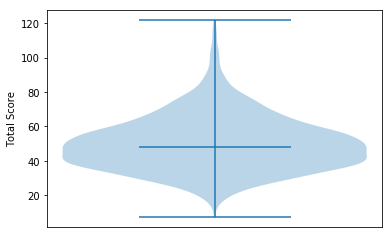

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 2.50%
Accuracy with +/- 5 Spread: 25.80%
Accuracy with +/- 10 Spread: 49.70%
Accuracy with +/- 15 Spread: 68.70%
Root Mean Squared Error: 15.38


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 2.70%
Accuracy with +/- 5 Spread: 26.10%
Accuracy with +/- 10 Spread: 48.00%
Accuracy with +/- 15 Spread: 65.80%
Root Mean Squared Error: 16.86


XGBOOST REGRESSION
---------------------------------
Accuracy: 2.30%
Accuracy with +/- 5 Spread: 20.00%
Accuracy with +/- 10 Spread: 45.90%
Accuracy with +/- 15 Spread: 65.90%
Root Mean Squared Error: 17.57


Epoch 00227: early stopping
NEURAL NETWORK REGRESSION
---------------------------------
Root Mean Squared Error: 0.15


Epoch 00438: early stopping
NEURAL NETWORK REGRESSION - Model 2
---------------------------------
Root Mean Squared Error: 0.16


PATCH VERSION:  38
Dataset shape for patch version:  (2746, 12)
-----------------------------------------

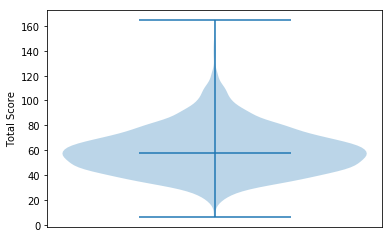

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 1.46%
Accuracy with +/- 5 Spread: 20.93%
Accuracy with +/- 10 Spread: 41.31%
Accuracy with +/- 15 Spread: 58.42%
Root Mean Squared Error: 19.23


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 1.73%
Accuracy with +/- 5 Spread: 21.66%
Accuracy with +/- 10 Spread: 42.58%
Accuracy with +/- 15 Spread: 59.33%
Root Mean Squared Error: 18.28


XGBOOST REGRESSION
---------------------------------
Accuracy: 1.55%
Accuracy with +/- 5 Spread: 19.29%
Accuracy with +/- 10 Spread: 39.49%
Accuracy with +/- 15 Spread: 55.87%
Root Mean Squared Error: 19.61


Epoch 00223: early stopping
NEURAL NETWORK REGRESSION
---------------------------------
Root Mean Squared Error: 0.12


Epoch 00433: early stopping
NEURAL NETWORK REGRESSION - Model 2
---------------------------------
Root Mean Squared Error: 0.14


PATCH VERSION:  39
Dataset shape for patch version:  (2467, 12)
-----------------------------------------

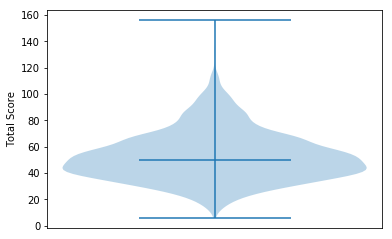

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 2.13%
Accuracy with +/- 5 Spread: 21.48%
Accuracy with +/- 10 Spread: 41.64%
Accuracy with +/- 15 Spread: 61.20%
Root Mean Squared Error: 19.60


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 2.74%
Accuracy with +/- 5 Spread: 21.58%
Accuracy with +/- 10 Spread: 42.55%
Accuracy with +/- 15 Spread: 60.99%
Root Mean Squared Error: 18.33


XGBOOST REGRESSION
---------------------------------
Accuracy: 2.33%
Accuracy with +/- 5 Spread: 21.38%
Accuracy with +/- 10 Spread: 39.72%
Accuracy with +/- 15 Spread: 56.74%
Root Mean Squared Error: 21.65


Epoch 00131: early stopping
NEURAL NETWORK REGRESSION
---------------------------------
Root Mean Squared Error: 0.13


Epoch 00496: early stopping
NEURAL NETWORK REGRESSION - Model 2
---------------------------------
Root Mean Squared Error: 0.15


PATCH VERSION:  40
Dataset shape for patch version:  (4952, 12)
-----------------------------------------

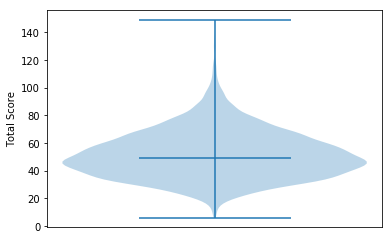

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 2.27%
Accuracy with +/- 5 Spread: 22.31%
Accuracy with +/- 10 Spread: 42.55%
Accuracy with +/- 15 Spread: 61.38%
Root Mean Squared Error: 16.96


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 2.17%
Accuracy with +/- 5 Spread: 22.41%
Accuracy with +/- 10 Spread: 43.77%
Accuracy with +/- 15 Spread: 62.29%
Root Mean Squared Error: 17.30


XGBOOST REGRESSION
---------------------------------
Accuracy: 1.82%
Accuracy with +/- 5 Spread: 20.95%
Accuracy with +/- 10 Spread: 41.75%
Accuracy with +/- 15 Spread: 59.26%
Root Mean Squared Error: 19.49


Epoch 00149: early stopping
NEURAL NETWORK REGRESSION
---------------------------------
Root Mean Squared Error: 0.13


Epoch 00449: early stopping
NEURAL NETWORK REGRESSION - Model 2
---------------------------------
Root Mean Squared Error: 0.14


PATCH VERSION:  41
Dataset shape for patch version:  (7006, 12)
-----------------------------------------

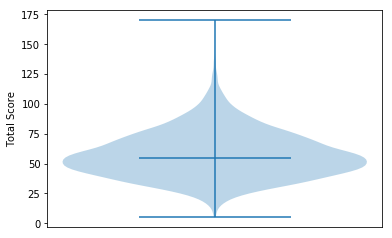

LINEAR REGRESSION
---------------------------------
Exact Answer Accuracy: 1.71%
Accuracy with +/- 5 Spread: 19.98%
Accuracy with +/- 10 Spread: 38.32%
Accuracy with +/- 15 Spread: 54.12%
Root Mean Squared Error: 19.96


RANDOM FOREST REGRESSION
---------------------------------
Accuracy: 1.93%
Accuracy with +/- 5 Spread: 20.87%
Accuracy with +/- 10 Spread: 39.28%
Accuracy with +/- 15 Spread: 56.30%
Root Mean Squared Error: 19.53




In [ ]:
for i in range(min(df_prof['patch'].astype('int64')), max(df_prof['patch'].astype('int64')) + 1):
    if df_prof.loc[df_prof['patch'] == i].shape[0] > 2000:
        print("PATCH VERSION: ", i)
        print("Dataset shape for patch version: ", df_prof.loc[df_prof['patch'] == i].shape)
        print("---------------------------------------------")
        run_all(df_prof.loc[df_prof['patch'] == i])
